In [105]:
import mne
import pandas as pd
import tools.helpers
import os 
import numpy as np


from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()


In [106]:
# read the raw file
participant_id = 11
participant_name = 'P' + str(participant_id)
partipant_data_path =  participant_name + '/' + participant_name +'.gdf'
path = os.path.join(configss['root'], configss['data_dir'] , partipant_data_path ) 
print(path)
raw  = mne.io.read_raw_gdf(path, preload=True)

# add filtering


c:\Users\erang\Desktop\Oddball\ov_experiment/scenarios/data\P11/P11.gdf
Extracting EDF parameters from c:\Users\erang\Desktop\Oddball\ov_experiment\scenarios\data\P11\P11.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
1Z, 2Z, 3Z, 4Z, 6Z, 7Z, 8Z, 9Z, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 1R, 2R, 3R, 4R, 5R, 6R, 7R, 8R, 9R, 10R, 11R, 1LA, 2LA, 3LA, 1LB, 2LB, 3LB, 4LB, 5LB, 1LC, 2LC, 3LC, 4LC, 5LC, 1LD, 2LD, 3LD, 4LD, 1RA, 2RA, 3RA, 1RB, 2RB, 3RB, 4RB, 5RB, 1RC, 2RC, 3RC, 4RC, 5RC, 1RD, 2RD, 3RD, 4RD, Tgt, SC
Creating raw.info structure...
Reading 0 ... 120319  =      0.000 ...   240.638 secs...


In [3]:
    data_channels = [x for x in raw.ch_names if x not in 
                     configss['non_data_channels']]

In [4]:
len(data_channels)

64

In [107]:
events_from_annot, event_dict =  mne.events_from_annotations(raw)

Used Annotations descriptions: ['27', '32769', '32770', '32773', '32774', '32780', '33025', '33026', '33184', '33185', '33200', '33201', '33202', '33279', '786', '898']


In [4]:
import numpy as np
np.unique(events_from_annot[:,-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [5]:
event_dict

{'27': 1,
 '32769': 2,
 '32770': 3,
 '32773': 4,
 '32774': 5,
 '32780': 6,
 '33025': 7,
 '33026': 8,
 '33184': 9,
 '33185': 10,
 '33200': 11,
 '33201': 12,
 '33202': 13,
 '33279': 14,
 '786': 15,
 '898': 16}

In [108]:
stimcodes =  tools.helpers.getOVStimCodes()
stimGroups = tools.helpers.getStimGroups()

In [109]:
inv_stimCodesMap =  { v: k for k, v in stimcodes.items()}
inv_stimGroupsMap = { v: k for k, v in stimGroups.items() }

In [110]:
import json 
print(json.dumps(inv_stimGroupsMap, indent=4, sort_keys=True))

{
    "OVTK_GDF_Cross_On_Screen": "visual/image_display/onset/fixation_cross",
    "OVTK_StimulationId_BaselineStart": "timing/baseline/start",
    "OVTK_StimulationId_BaselineStop": "timing/baseline/stop",
    "OVTK_StimulationId_ExperimentStart": "timing/experiment/start",
    "OVTK_StimulationId_ExperimentStop": "timing/experiment/stop",
    "OVTK_StimulationId_Label_01": "visual/image_display/onset/stimulus/non_freq",
    "OVTK_StimulationId_Label_02": "visual/image_display/onset/stimulus/freq",
    "OVTK_StimulationId_Label_A0": "visual/image_display/onset/instruction/set_0/instruction_0",
    "OVTK_StimulationId_Label_A1": "visual/image_display/onset/instruction/set_0/instruction_1",
    "OVTK_StimulationId_Label_B0": "visual/image_display/onset/instruction/set_1/instruction_0",
    "OVTK_StimulationId_Label_B1": "visual/image_display/onset/instruction/set_1/instruction_1",
    "OVTK_StimulationId_Label_B2": "visual/image_display/onset/instruction/set_2/instruction_0",
    "OVTK_

In [9]:
stimcodes['OVTK_GDF_Incorrect']

898

In [111]:
modified_event_dict =  { inv_stimGroupsMap[inv_stimCodesMap[int(k)]] :v for k,v in event_dict.items() if inv_stimCodesMap[int(k)] in inv_stimGroupsMap}
epoch_event_dict =  {k:v for k, v in modified_event_dict.items() if ('freq' in k) or ('set_1/instruction_1' in k)}

In [112]:
import json 
print(json.dumps(epoch_event_dict, indent=4, sort_keys=True))

{
    "visual/image_display/onset/instruction/set_1/instruction_1": 12,
    "visual/image_display/onset/stimulus/freq": 8,
    "visual/image_display/onset/stimulus/non_freq": 7
}


In [89]:
epochs = mne.Epochs(raw,  events=events_from_annot,
    event_id=epoch_event_dict, tmin=-0.3, tmax=0.7, preload=True)

Not setting metadata
123 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 123 events and 501 original time points ...
0 bad epochs dropped


In [113]:
metadata_tmin, metadata_tmax = -0.3, 0.7

row_events = [
    'visual/image_display/onset/stimulus/non_freq',
    'visual/image_display/onset/stimulus/freq',
    'visual/image_display/onset/instruction/set_1/instruction_1'
]


metadata, meta_events, meta_event_id = mne.epochs.make_metadata(
    events=events_from_annot,
    event_id= modified_event_dict, 
    row_events = row_events,
    # event_id=epoch_event_dict, 
    tmin=metadata_tmin,
    tmax=metadata_tmax,
    sfreq=raw.info["sfreq"],
    keep_first= ['visual/image_display/onset/stimulus']

)

metadata

,event_name,keyboard/button_pressed/control/space,timing/experiment/start,timing/experiment/stop,timing/trial/start,timing/trial/stop,visual/image_display/clear_image,visual/image_display/onset/stimulus/non_freq,visual/image_display/onset/stimulus/freq,visual/image_display/onset/instruction/set_0/instruction_0,visual/image_display/onset/instruction/set_0/instruction_1,visual/image_display/onset/instruction/set_1/instruction_0,visual/image_display/onset/instruction/set_1/instruction_1,visual/image_display/onset/instruction/set_2/instruction_0,keyboard/button_released,visual/image_display/onset/fixation_cross,visual/image_display/onset/stimulus,first_visual/image_display/onset/stimulus
12,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,freq
17,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,freq
22,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,non_freq
27,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,freq
32,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,freq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,-0.3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.294,0.0,non_freq
610,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.294,0.0,non_freq
615,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.296,0.0,freq
620,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.300,0.0,freq


In [114]:
# there are no overlapping raws
metadata.loc[metadata['visual/image_display/onset/stimulus/non_freq'].notna()
              & metadata['visual/image_display/onset/stimulus/freq'].notna()]
              

,event_name,keyboard/button_pressed/control/space,timing/experiment/start,timing/experiment/stop,timing/trial/start,timing/trial/stop,visual/image_display/clear_image,visual/image_display/onset/stimulus/non_freq,visual/image_display/onset/stimulus/freq,visual/image_display/onset/instruction/set_0/instruction_0,visual/image_display/onset/instruction/set_0/instruction_1,visual/image_display/onset/instruction/set_1/instruction_0,visual/image_display/onset/instruction/set_1/instruction_1,visual/image_display/onset/instruction/set_2/instruction_0,keyboard/button_released,visual/image_display/onset/fixation_cross,visual/image_display/onset/stimulus,first_visual/image_display/onset/stimulus


In [119]:
metadata["oddball"] = False
metadata["control"] = False
metadata.loc[ metadata['first_visual/image_display/onset/stimulus'] == 'non_freq', "oddball" ] = True 
metadata.loc[ metadata['first_visual/image_display/onset/stimulus'] == 'freq', "control" ] = True 

In [120]:

mask = metadata['visual/image_display/onset/instruction/set_1/instruction_1'] == 0.0

relavent_indexes = metadata[mask].index

#initialize column
metadata.loc[:, "block"] = ""

for i in range(len(relavent_indexes)):
    from_index =  relavent_indexes[i -1] if i > 0 else 0
    to_index = relavent_indexes[i]
    metadata.loc[from_index: to_index, "block"] = "b" + str(i)



In [121]:
metadata

,event_name,keyboard/button_pressed/control/space,timing/experiment/start,timing/experiment/stop,timing/trial/start,timing/trial/stop,visual/image_display/clear_image,visual/image_display/onset/stimulus/non_freq,visual/image_display/onset/stimulus/freq,visual/image_display/onset/instruction/set_0/instruction_0,...,visual/image_display/onset/instruction/set_1/instruction_0,visual/image_display/onset/instruction/set_1/instruction_1,visual/image_display/onset/instruction/set_2/instruction_0,keyboard/button_released,visual/image_display/onset/fixation_cross,visual/image_display/onset/stimulus,first_visual/image_display/onset/stimulus,oddball,control,block
12,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,freq,False,True,b0
17,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,freq,False,True,b0
22,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,non_freq,True,False,b0
27,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,freq,False,True,b0
32,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,freq,False,True,b0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,-0.3,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.294,0.0,non_freq,True,False,b2
610,visual/image_display/onset/stimulus/non_freq,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.294,0.0,non_freq,True,False,b2
615,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,-0.296,0.0,freq,False,True,b2
620,visual/image_display/onset/stimulus/freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,-0.300,0.0,freq,False,True,b2


In [97]:
epochs = mne.Epochs(raw, meta_events, event_id=meta_event_id , tmin=-0.3, tmax=0.7, preload=True, metadata = metadata)

Adding metadata with 7 columns
123 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 123 events and 501 original time points ...
0 bad epochs dropped


In [102]:
meta_event_id

{'visual/image_display/onset/stimulus/non_freq': 7,
 'visual/image_display/onset/stimulus/freq': 8,
 'visual/image_display/onset/instruction/set_1/instruction_1': 12}

In [90]:
epochs = mne.Epochs(raw,  events=events_from_annot,
    event_id=epoch_event_dict,  metadata = metadata, tmin=-0.3, tmax=0.7, preload=True)

ValueError: metadata must have the same number of rows (123) as events (628)

In [77]:
metadata

,event_name,visual/image_display/onset/stimulus/non_freq,visual/image_display/onset/stimulus/freq,visual/image_display/onset/instruction/set_1/instruction_1,visual/image_display/onset/stimulus,first_visual/image_display/onset/stimulus,block
12,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b0
17,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b0
22,visual/image_display/onset/stimulus/non_freq,0.0,NaN,NaN,0.0,non_freq,b0
27,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b0
32,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b0
...,...,...,...,...,...,...,...
605,visual/image_display/onset/stimulus/non_freq,0.0,NaN,NaN,0.0,non_freq,b2
610,visual/image_display/onset/stimulus/non_freq,0.0,NaN,NaN,0.0,non_freq,b2
615,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b2
620,visual/image_display/onset/stimulus/freq,NaN,0.0,NaN,0.0,freq,b2


In [36]:
metadata.iloc[relavent_indexes]

,event_name,visual/image_display/onset/stimulus/non_freq,visual/image_display/onset/stimulus/freq,visual/image_display/onset/instruction/set_1/instruction_1
210,visual/image_display/onset/instruction/set_1/i...,NaN,NaN,0.0
416,visual/image_display/onset/instruction/set_1/i...,NaN,NaN,0.0
623,visual/image_display/onset/instruction/set_1/i...,NaN,NaN,0.0


In [52]:
raw_bandpass_filter = raw.copy().filter(l_freq=configss['l_freq'], h_freq=configss['h_freq'])

# raw_notch_filter =  raw.copy().notch_filter(freqs=freqs, picks=meg_picks)

Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 8.192 (s)


c:\Users\erang\AppData\Local\pypoetry\Cache\virtualenvs\oddball-KYxTObZq-py3.8\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


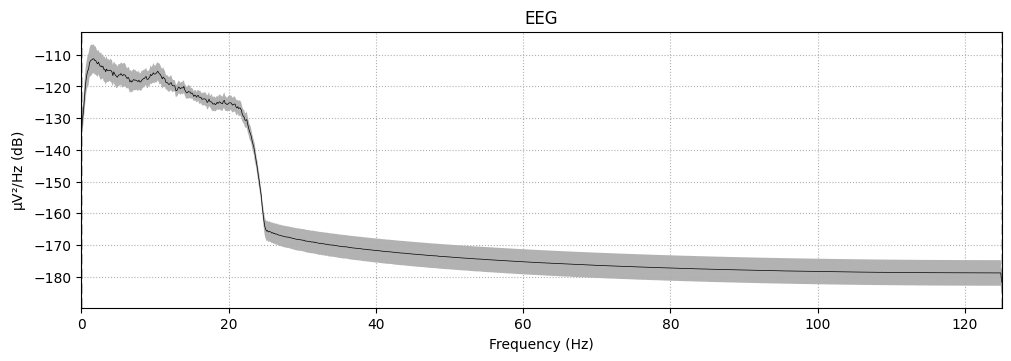

In [66]:
(
    raw
    .copy()
    .pick(data_channels)
    .compute_psd(fmax=raw.info["sfreq"] / 2)
    .plot(average=True)
)

Effective window size : 4.096 (s)


C:\Users\erang\AppData\Local\Temp\ipykernel_17548\1593834440.py:1: UserWarning: Zero value in spectrum for channel Tgt
  raw_bandpass_filter.compute_psd(fmax=250).plot()
C:\Users\erang\AppData\Local\Temp\ipykernel_17548\1593834440.py:1: UserWarning: Infinite value in PSD for channel Tgt.
These channels might be dead.
  raw_bandpass_filter.compute_psd(fmax=250).plot()
C:\Users\erang\AppData\Local\Temp\ipykernel_17548\1593834440.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_bandpass_filter.compute_psd(fmax=250).plot()
c:\Users\erang\AppData\Local\pypoetry\Cache\virtualenvs\oddball-KYxTObZq-py3.8\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


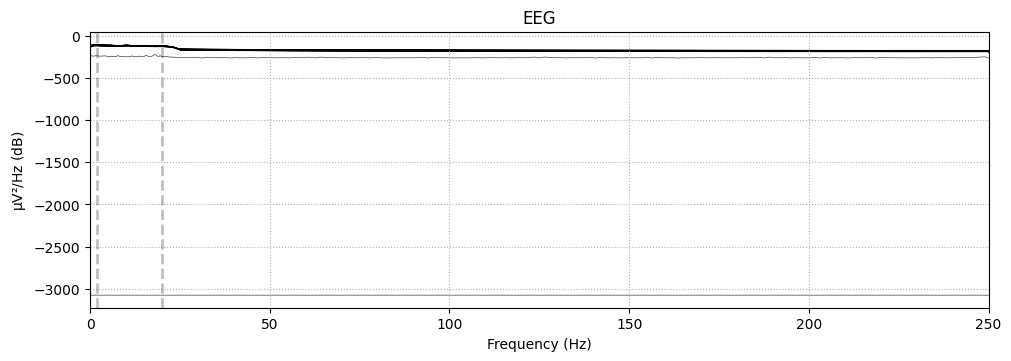